In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold



In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


##### In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

#### Data preparation
##### Check if the missing values are presented in the features.
##### If there are missing values:
##### For caterogiral features, replace them with 'NA'
##### For numerical features, replace with with 0.0
##### Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
# Separate categorical and numerical columns
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(exclude=['object']).columns

# Fill missing values
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)


In [5]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [6]:
# First split: train_temp (80%) + test (20%)
df_train_temp, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Second split: train (75% of 80%) + validation (25% of 80%) = 60/20/20 overall
df_train, df_val = train_test_split(df_train_temp, test_size=0.25, random_state=1)

# Check the proportions
print(len(df_train), len(df_val), len(df_test))



876 293 293


#### Question 1: ROC AUC feature importance
##### ROC AUC could also be used to evaluate feature importance of numerical variables.

##### Let's do that

##### For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
##### Use the training dataset for that
##### If your AUC is < 0.5, invert this variable by putting "-" in front

##### (e.g. -df_train['balance'])

##### AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

##### Which numerical variable (among the following 4) has the highest AUC?

In [7]:

# Define the target variable and numeric features to test
Target = 'converted'  # this determines whether the client signed up or not
Features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']


In [8]:
# Compute ROC AUC for each numeric feature
for f in Features:
    auc = roc_auc_score(df_train[Target], df_train[f])
    # Invert if AUC < 0.5
    if auc < 0.5:
        auc = roc_auc_score(df_train[Target], -df_train[f])
    print(f"{f}: {auc:.3f}")


lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


#### Question 2: Training the model
##### Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

##### LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
##### What's the AUC of this model on the validation dataset? (round to 3 digits)

In [9]:
# Separating the target variable (converted) and the features.

y_train = df_train['converted']
y_val = df_val['converted']

# Drop target from feature sets
X_train = df_train.drop('converted', axis=1)
X_val = df_val.drop('converted', axis=1)


In [ ]:
# Convert categorical columns using DictVectorizer
# Convert to dictionary format
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)


In [ ]:
# Next is to train Logistic Regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
# Then evaluate on Validation Set (ROC AUC)

y_pred_val = model.predict_proba(X_val_encoded)[:, 1]
auc = roc_auc_score(y_val, y_pred_val)
print(f"Validation AUC: {auc:.3f}")


Validation AUC: 0.817


#### Question 3: Precision and Recall
##### Now let's compute precision and recall for our model.

##### Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
##### For each threshold, compute precision and recall
##### Plot them
##### At which threshold precision and recall curves intersect?

In [13]:
# Compute precision & recall at each threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision = []
recall = []

for t in thresholds:
    preds = (y_pred_val >= t)
    precision.append(precision_score(y_val, preds))
    recall.append(recall_score(y_val, preds))

/workspaces/Machine-Learning-1st-Assigmnment/MLHomework/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/Machine-Learning-1st-Assigmnment/MLHomework/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/Machine-Learning-1st-Assigmnment/MLHomework/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _

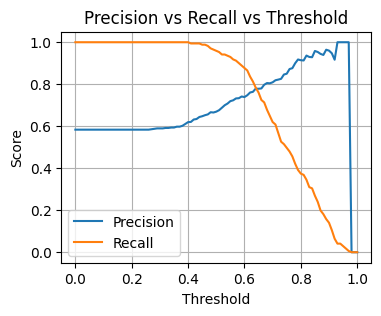

In [14]:
# Plot the intersection between precision-recall curves
plt.figure(figsize=(4,3))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

#### Question 4: F1 score
##### Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

##### This is the formula for computing F1: F1 = 2*P*R/P+R
##### At which threshold F1 is maximal?

In [15]:
# Compute F1 at every threshold

f1 = []

for p, r in zip(precision, recall):
    if p + r == 0:
        f1.append(0)
    else:
        f1.append(2 * (p * r / (p + r)))


In [16]:
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
best_f1 = f1[best_idx]

print(f"F1 = {best_f1:.3f} Maximum at {best_threshold:.2f} thhreshold")


F1 = 0.812 Maximum at 0.57 thhreshold


#### Question 5: 5-Fold CV
##### Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

##### KFold(n_splits=5, shuffle=True, random_state=1)
##### Iterate over different folds of df_full_train
##### Split the data into train and validation
##### Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
##### Use AUC to evaluate the model on validation
##### How large is standard deviation of the scores across different folds?

In [17]:
#- KFold(n_splits=5, shuffle=True, random_state=1)


kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Placeholder for AUC scores
scores = []


In [18]:


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_full_train = df_full_train.reset_index(drop=True)


In [19]:
# Define feature and target columns
target_col = 'converted'   
feature_cols = [col for col in df_full_train.columns if col != target_col]



In [20]:
# Prepare data
# One-hot encode categorical features
df_full_encoded = pd.get_dummies(df_full_train[feature_cols], drop_first=True)
X = df_full_encoded
y = df_full_train[target_col]



In [ ]:
##### KFold(n_splits=5, shuffle=True, random_state=1)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

##### Iterate over different folds of df_full_train & Split the data into train and validation
auc_scores = []

for train_index, val_index in kf.split(X):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model on train with these parameters
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Use AUC to evaluate the model on validation
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)    

In [36]:
# How large is standard deviation of the scores across different folds?
print("AUC scores for each fold:", np.round(auc_scores, 3))
print("Mean AUC:", np.mean(auc_scores).round(3))
print("Standard Deviation:", np.std(auc_scores).round(3))


AUC scores for each fold: [0.806 0.871 0.774 0.801 0.855]
Mean AUC: 0.822
Standard Deviation: 0.036


#### Question 6: Hyperparameter Tuning
##### Now let's use 5-Fold cross-validation to find the best parameter C

##### Iterate over the following C values: [0.000001, 0.001, 1]
##### Initialize KFold with the same parameters as previously
##### Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
##### Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
##### Which C leads to the best mean score?

In [33]:

y = df_full_train[target_col]

##### Define hyperparameters to test
C_values = [0.000001, 0.001, 1]


kf = KFold(n_splits=5, shuffle=True, random_state=1)

##### Iterate over C values & Split the data into train and validation
for C in C_values:
    auc_scores = []

    for train_index, val_index in kf.split(X):
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model on train with these parameters
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Use AUC to evaluate the model on validation
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)    

        ##### Compute mean and std
        mean_auc = np.mean(auc_scores)
        std_auc = np.std(auc_scores)

In [34]:
print(f"C={C}")
print(f"Mean AUC: {mean_auc:.3f}")
print(f"Std AUC:  {std_auc:.3f}")



C=1
Mean AUC: 0.822
Std AUC:  0.036
